# Parsing and Recombining Inputs

In this chapter, we use grammars to parse and decompose inputs, allowing us to recombine them arbitrarily.
\todo{Work in progress.}
* Specify the restrictions due to precedence
* Specify the class of languages covered (what is the overlap with CFG)
* Specify the restrictions on our implementation (parsing predicates)

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import EXPR_GRAMMAR, START_SYMBOL

In [3]:
from GrammarFuzzer import display_tree

In [4]:
import functools
import re

RE_NONTERMINAL = re.compile(r'(<[a-zA-Z_]*>)')

def split(rule):
    return [s for s in re.split(RE_NONTERMINAL, rule) if s]

In [5]:
class PEGParser:
    def __init__(self, grammar):
        self.grammar = {k: [split(l) for l in rules]
                        for k, rules in grammar.items()}
    # memoize repeated calls.
    @functools.lru_cache(maxsize=None)
    def unify_key(self, key, text, at=0):
        if key not in self.grammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        rules = self.grammar[key]
        for rule in rules:
            l, res = self.unify_line(rule, text, at)
            if res: return (l, (key, res))
        return 0, None

    def unify_line(self, rule, text, at):
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, at)
            if res is None: return at, None
            results.append(res)
        return at, results

In [6]:
def parse(text, grammar, start_symbol=START_SYMBOL):
    peg = PEGParser(grammar)
    return peg.unify_key(start_symbol, text)

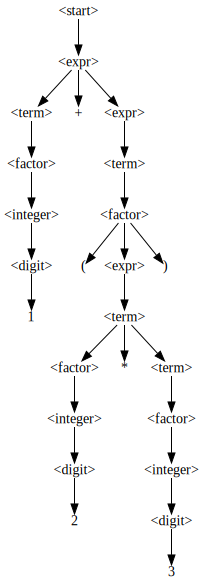

In [7]:
cursor, tree = parse("1 + (2 * 3)", EXPR_GRAMMAR)
display_tree(tree)

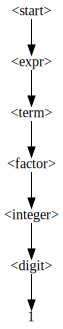

In [8]:
cursor, tree = parse("1 * (2 + 3.45)", EXPR_GRAMMAR)
display_tree(tree)

## Table driven parsers

Parsing Expression Grammars specifically oriented towards writing recognizers. Unfortunately, Parsing Expression Grammars are not suitable for grammar based fuzzing. \todo{Verify, and explain how precedence in parsing is not translatable to generation}.
\todo{Explain LL(k), LR(k), and general Context-Free parsers such as Early and CYK parsers}


### LL(1) parser

LL(k) parsers are top-down parsers that rely on a lookahead of k tokens. We provide an implementation of an LL(1) parser.

We first need to define a few tokens that will come in handy.

In [9]:
EOF = '\0'
EPSILON = ''

LL(1) grammars are rather restrictive. Specifically, the grammar should not contain left recursion. Hence, we have to
update our original grammar to remove left-recursion.

In [10]:
grammar = {'<start>': ['<expr>'],
           '<expr>': ['<term><expr_>'],
           '<expr_>': ['+<expr>',
                       '-<expr>',
                       ''],
           '<term>': ['<factor><term_>'],
           '<term_>': ['*<term>',
                       '/<term>',
                       ''],
           '<factor>': ['+<factor>',
                        '-<factor>',
                        '(<expr>)',
                        '<int>'],
           '<int>': ['<integer><integer_>'],
           '<integer_>': ['',
                          '.<integer>'],
           '<integer>': ['<digit><I>'],
           '<I>': ['<integer>',
                   ''],
           '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

Next, we need to change the grammar so that the productions become tokens

In [11]:
new_grammar = {k: [split(e) for e in grammar[k]] for k in grammar}
new_grammar

{'<start>': [['<expr>']],
 '<expr>': [['<term>', '<expr_>']],
 '<expr_>': [['+', '<expr>'], ['-', '<expr>'], []],
 '<term>': [['<factor>', '<term_>']],
 '<term_>': [['*', '<term>'], ['/', '<term>'], []],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<int>']],
 '<int>': [['<integer>', '<integer_>']],
 '<integer_>': [[], ['.', '<integer>']],
 '<integer>': [['<digit>', '<I>']],
 '<I>': [['<integer>'], []],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

We also need to get the listing of production rules, and the set of terminals in the grammar

In [12]:
def rules(g): return [(k, e) for k, a in g.items() for e in a]

In [13]:
def terminals(g):
    return set(t for k, expr in rules(g) for t in expr if t not in g)

### First and Follow sets

\todo{Define first and follow sets}
We first define the fixpiont
\todo{Define what is a fixpoint of a function}

In [14]:
def fixpoint(f):
    def helper(*args):
        while True:
            sargs = repr(args)
            args_ = f(*args)
            if repr(args_) == sargs:
                return args
            args = args_
    return helper

In [15]:
@fixpoint
def nullable_(rules, e):
    for A, expression in rules:
        if all((token in e)  for token in expression): e |= {A}
    return (rules, e)

def nullable(grammar):
    return nullable_(rules(grammar), set())[1]


@fixpoint
def firstset_(rules, first, epsilon):
    for A, expression in rules:
        for token in expression:
            first[A] |= first[token]

            # update until the first token that is not nullable
            if token not in epsilon:
                break
    return (rules, first, epsilon)

def firstset(grammar, epsilon):
    # https://www.cs.umd.edu/class/spring2014/cmsc430/lectures/lec05.pdf p6
    # (1) If X is a terminal, then First(X) is just X
    first = {i:{i} for i in terminals(grammar)}

    # (2) if X ::= epsilon, then epsilon \in First(X)
    for k in grammar:
        first[k] = {EPSILON} if k in epsilon else set()
    return firstset_(rules(grammar), first, epsilon)[1]

@fixpoint
def followset_(grammar, epsilon, first, follow):
    for A, expression in rules(grammar):
        # https://www.cs.umd.edu/class/spring2014/cmsc430/lectures/lec05.pdf
        # https://www.cs.uaf.edu/~cs331/notes/FirstFollow.pdf
        # essentially, we start from the end of the expression. Then:
        # (3) if there is a production A -> aB, then every thing in
        # FOLLOW(A) is in FOLLOW(B)
        # note: f_B serves as both follow and first.
        f_B = follow[A]
        for t in reversed(expression):
            # update the follow for the current token. If this is the
            # first iteration, then here is the assignment
            if t in grammar:
                follow[t] |= f_B  # only bother with nt

            # computing the last follow symbols for each token t. This
            # will be used in the next iteration. If current token is
            # nullable, then previous follows can be a legal follow for
            # next. Else, only the first of current token is legal follow
            # essentially

            # (2) if there is a production A -> aBb then everything in FIRST(B)
            # except for epsilon is added to FOLLOW(B)
            f_B = f_B | first[t] if t in epsilon else (first[t] - {EPSILON})

    return (grammar, epsilon, first, follow)

In [16]:
def followset(grammar, start):
    # Initialize first and follow sets for non-terminals
    follow = {i: set() for i in grammar}
    follow[start] = {EOF}

    epsilon = nullable(grammar)
    first = firstset(grammar, epsilon)
    return followset_(grammar, epsilon, first, follow)

In [17]:
def rnullable(rule, epsilon):
    return all(token in epsilon for token in rule)

In [18]:
def rfirst(rule, first, epsilon):
    tokens = set()
    for token in rule:
        tokens |= first[token]
        if token not in epsilon: break
    return tokens

In [19]:
def predict(rulepair, first, follow, epsilon):
    A, rule = rulepair
    rf = rfirst(rule, first, epsilon)
    if rnullable(rule, epsilon):
        rf |= follow[A]
    return rf

In [20]:
def parse_table(grammar, start, my_rules):
    _, epsilon, first, follow = followset(grammar, start)

    ptable = [(rule, predict(rule, first, follow, epsilon))
              for rule in my_rules]

    parse_tbl = {k: {} for k in grammar}

    for (k, expr), pvals in ptable:
        parse_tbl[k].update({v: (k, expr) for v in pvals})
    return parse_tbl

In [21]:
def parse_helper(grammar, tbl, stack, inplst):
    inp, *inplst = inplst
    exprs = []
    while stack:
        val, *stack = stack
        if isinstance(val, tuple):
            exprs.append(val)
        elif val not in grammar:  # terminal
            assert val == inp
            exprs.append(val)
            inp, *inplst = inplst or [None]
        else:
            _, rhs = tbl[val][inp] if inp else (None, [])
            stack = rhs + [(val, len(rhs))] + stack
    return exprs

In [22]:
def parse(grammar, start, inp):
    my_rules = rules(grammar)
    parse_tbl = parse_table(grammar, start, my_rules)
    k, _ = my_rules[0]
    stack = [k]
    return parse_helper(grammar, parse_tbl, stack, list(inp))

In [23]:
def linear_to_tree(arr):
    stack = []
    while arr:
        elt = arr.pop(0)
        if not isinstance(elt, tuple):
            stack.append((elt, []))
        else:
            # get the last n
            sym, n = elt
            elts = stack[-n:] if n > 0 else []
            stack = stack[0:len(stack) - n]
            stack.append((sym, elts))
    assert len(stack) == 1
    return stack[0]

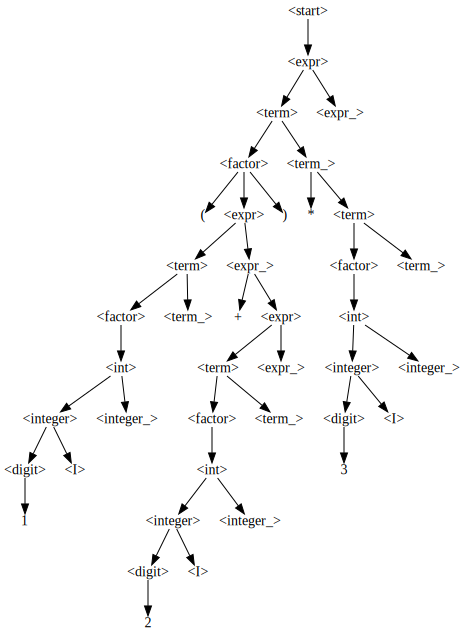

In [24]:
tree = linear_to_tree(parse(new_grammar, START_SYMBOL, '(1+2)*3'))
display_tree(tree)

### Earley parser

In [25]:
def shrink(rule): return [i.strip() for i in rule]

In [26]:
new_grammar = {k: [shrink(split(e)) for e in EXPR_GRAMMAR[k]] for k in EXPR_GRAMMAR}
new_grammar

{'<start>': [['<expr>']],
 '<expr>': [['<term>', '+', '<expr>'], ['<term>', '-', '<expr>'], ['<term>']],
 '<term>': [['<factor>', '*', '<term>'],
  ['<factor>', '/', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [27]:
@fixpoint
def nullable_(rules, e):
    for A, expression in rules:
        if all((token in e)  for token in expression): e |= {A}
    return (rules, e)

def nullable(grammar):
    return nullable_(rules(grammar), set())[1]

In [28]:
class State(object):
    def __init__(self, name, expr, dot, origin, children=[]):
        self.name, self.expr, self.dot, self.origin = name, expr, dot, origin
        self.children = children[:]
    def finished(self): return self.dot >= len(self.expr)
    def shift(self):
        return State(self.name, self.expr, self.dot+1, self.origin, self.children)
    def symbol(self): return self.expr[self.dot]

    def _t(self): return (self.name, self.expr, self.dot, self.origin.i, tuple(self.children))
    def __hash__(self): return hash(self._t())
    def __eq__(self, other): return  self._t() == other._t()

class Column(object):
    def __init__(self, i, token):
        self.token, self.states, self._unique, self.i = token, [], {}, i

    def add(self, state):
        if state in self._unique: return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        return self._unique[state]

def predict(col, sym, grammar):
    for alt in grammar[sym]:
        col.add(State(sym, tuple(alt), 0, col))

def scan(col, state, token):
    if token == col.token:
        col.add(state.shift())

def complete(col, state, grammar):
    for st in state.origin.states:
        if st.finished(): continue
        if state.name != st.symbol(): continue
        col.add(st.shift()).children.append(state)

# http://courses.washington.edu/ling571/ling571_fall_2010/slides/parsing_earley.pdf
# https://github.com/tomerfiliba/tau/blob/master/earley3.py
def parse(words, grammar, start):
    # Aycock 2002 Practical Earley Parsing -- treatment of epsilon
    epsilon = nullable(grammar)
    alt = tuple(*grammar[start])
    chart = [Column(i, tok) for i,tok in enumerate([None, *words])]
    chart[0].add(State(start, alt, 0, chart[0], []))

    for i, col in enumerate(chart):
        for state in col.states:
            if state.finished():
                complete(col, state, grammar)
            else:
                sym = state.symbol()
                if sym in grammar:
                    predict(col, sym, grammar)
                    if sym in epsilon:
                        # note that precomputation of epsilon derivation can result in infinite
                        # loops for certain grammars. Hence, we mark a nullable non-terminal
                        # but do not expand it.
                        col.add(state.shift()).children.append(State(sym + '*', tuple(), 0, col))
                else:
                    if i + 1 >= len(chart): continue
                    scan(chart[i+1], state, sym)
    return chart

In [29]:
def process_expr(expr, children, grammar):
    terms = iter([(i,[]) for i in expr if i not in grammar])
    nts = iter([node_translator(i, grammar) for i in  children])
    return [next(terms if i not in grammar else nts) for i in expr]

def node_translator(state, grammar):
    return (state.name, process_expr(state.expr, state.children, grammar))

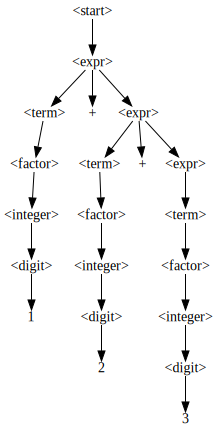

In [30]:
new_grammar = {k: [shrink(split(e)) for e in EXPR_GRAMMAR[k]] for k in EXPR_GRAMMAR}
table = parse(list('1+2+3'), new_grammar, '<start>')
states = [st for st in table[-1].states if st.name == '<start>' and st.finished()]
for state in states:
    display_tree(node_translator(state, new_grammar))

#### Ambiguous grammars generates parse forests

In [31]:
grammar= {
        '<start>': ['<A>'],
        '<A>': ['<A>+<A>', 'a'],
        }

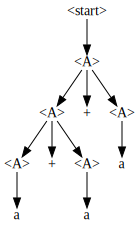

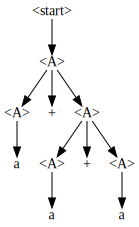

In [32]:
new_grammar = {k: [shrink(split(e)) for e in grammar[k]] for k in grammar}
table = parse(list('a+a+a'), new_grammar, '<start>')
states = [st for st in table[-1].states if st.name == '<start>' and st.finished()]
for state in states:
    display_tree(node_translator(state, new_grammar))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Exercises

Close the chapter with a few exercises such that people have things to do.  In Jupyter Notebook, use the `exercise2` nbextension to add solutions that can be interactively viewed or hidden:

* Mark the _last_ cell of the exercise (this should be a _text_ cell) as well as _all_ cells of the solution.  (Use the `rubberband` nbextension and use Shift+Drag to mark multiple cells.)
* Click on the `solution` button at the top.

(Alternatively, just copy the exercise and solution cells below with their metadata.)

### Exercise 1

_Text of the exercise_

In [33]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

_Some text for the solution_

In [34]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2

_Text of the exercise_

_Solution for the exercise_